__Autoencoder tries to reconstruct the input. So, both the input and label are the same.__

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


2025-04-22 23:03:53.264421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 23:03:53.264975: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 23:03:53.267162: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 23:03:53.272996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745341433.282819   43808 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745341433.28

## Data Preprocessing

In [2]:
def map_image(image, label):
  '''
  Normalizes the image. Returns image as input and label.
  '''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image


In [4]:
# Load the train and test sets from TFDS
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()


In [23]:
print("Train dataset spec:", train_dataset.element_spec)
print("Test dataset spec:", test_dataset.element_spec)


Train dataset spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))
Test dataset spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))


Image Shape:  (28, 28, 1)


2025-04-23 00:14:19.898178: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


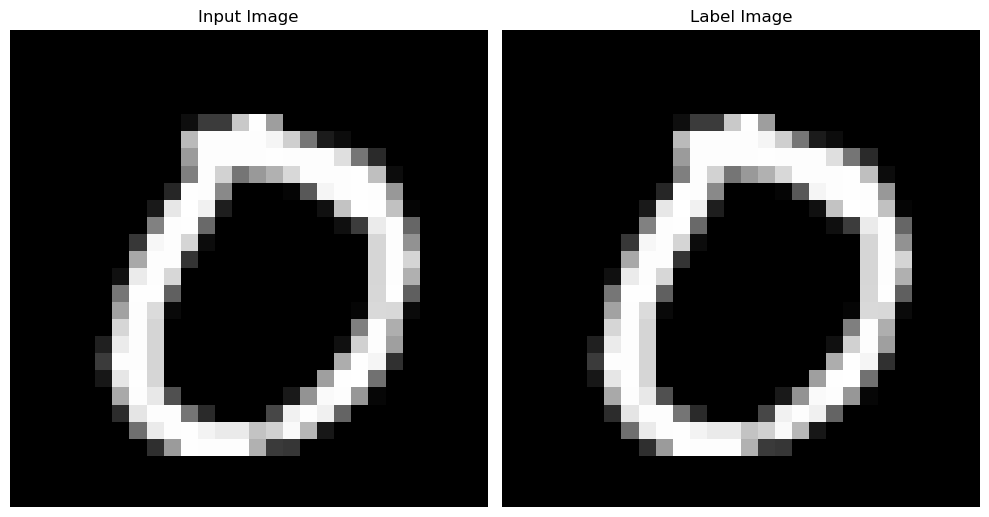

In [41]:
for image, label in train_dataset.take(1):
    image = image[0].numpy()
    label = label[0].numpy()
    break

print("Image Shape: ", image.shape)
# Plot the image and label
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot input image
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

# Plot label image (same as input for autoencoders)
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Label Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Build Autoencoder Model

In [42]:
# Model 1
image = image.flatten()
input_shape = image.shape
encoder = keras.models.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(128)
    ])

decoder = keras.models.Sequential([
    keras.Input(shape=(128, )),
    keras.layers.Dense(input_shape[0])
    ])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)      │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Model 2
autoencoder = keras.models.Sequential([
    # Input Layer
    keras.Input(shape=input_shape),

    # Encoder
    keras.layers.Dense(128),

    # Decoder
    keras.layers.Dense(input_shape[0])
])
autoencoder.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.01))


In [45]:
# Add batch dimension
image = tf.expand_dims(image, axis=0) # shape: (1, 784)

history = autoencoder.fit(image, image, epochs=200)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2085
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2072
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2059
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2047
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2034
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2022
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2010
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1998
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1986
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1974
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1963
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1952
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1941
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1930
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1919
Epoch 16/200
1/1 ━

In [48]:
# encode the data
encodings = encoder.predict(image)

# decode the encoder output
decodings = decoder.predict(encodings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


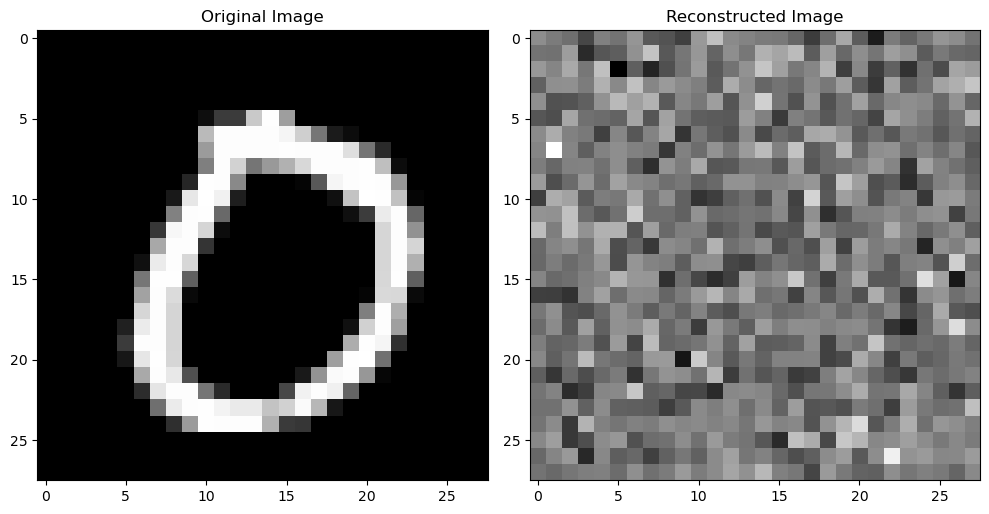

In [54]:
# Plot the input and output images
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Original input
axes[0].imshow(image.numpy().reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")

# Reconstructed image
axes[1].imshow(decodings.squeeze().reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")

plt.tight_layout()
plt.show()


## Build Deep Autoencoder Model

In [73]:
# Input Layer
inputs =  tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)

# Encoder
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
encoder = tf.keras.layers.Dense(units=32, activation='relu')(x)

# Decoder
x = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(x)

# Output reshaped to image
outputs = tf.keras.layers.Reshape((28, 28, 1))(decoder)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
train_steps = 60000 // BATCH_SIZE

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)


Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0811
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0798
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 10/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0798
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0798
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0799
Epoch 15/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


2025-04-23 01:36:10.878508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


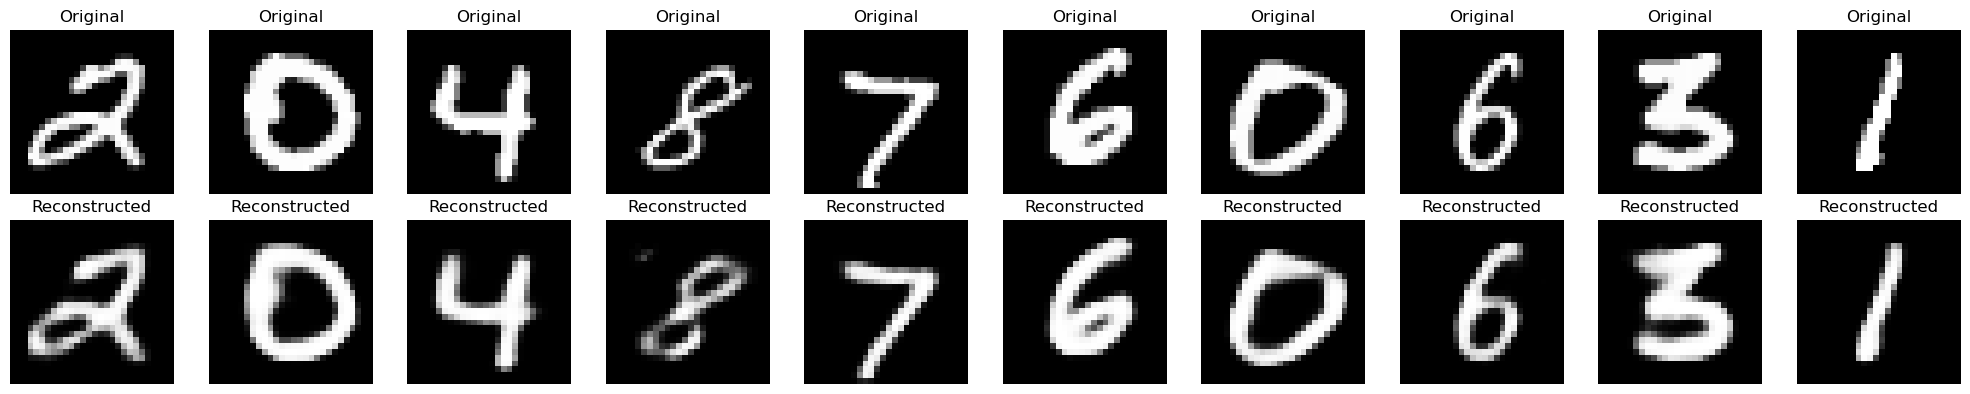

In [76]:
# Take a single batch from test_dataset
for batch in test_dataset.take(1):
    test_images, _ = batch  # Ignoring labels since it's autoencoder
    break

# Predict using the autoencoder model
reconstructed_images = model.predict(test_images)

# Plot original vs reconstructed
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(test_images[i]), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(reconstructed_images[i]), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Build Convolutional Autoencoder Model

In [81]:
# Input Layer
inputs = tf.keras.Input((28, 28, 1))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Crop to 28x28 if needed
decoded = tf.keras.layers.Cropping2D(((2, 2), (2, 2)))(decoded)  # 28x28x1

# Model
model = tf.keras.Model(inputs=inputs, outputs=decoded)
model.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

<p style="color:orange"><strong>You only need to set steps_per_epoch when:</strong></p>

<ul>
  <li>You’re using a <code>tf.data.Dataset</code> that is <em>infinitely repeating</em> (e.g. <code>train_dataset.repeat()</code>)</li>
  <li>Or when your dataset is not explicitly batched to total steps, so Keras can't auto-infer the steps</li>
</ul>


In [82]:
train_steps = 60000 // BATCH_SIZE

model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)


Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2346
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0820
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0757
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0729
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0711
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0699
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0691
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0683
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0678
Epoch 10/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0674
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0670
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0666
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0664
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0660
Epoch 15/50
468/468 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


2025-04-23 02:53:57.015360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


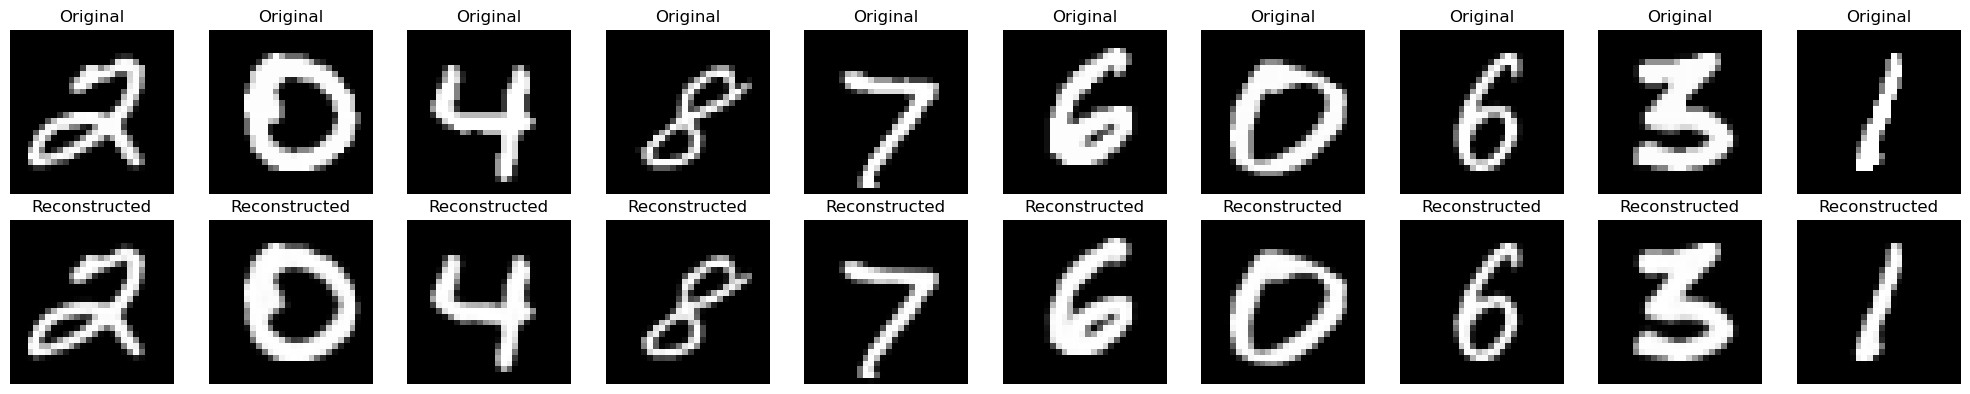

In [83]:
# Take a single batch from test_dataset
for batch in test_dataset.take(1):
    test_images, _ = batch  # Ignoring labels since it's autoencoder
    break

# Predict using the autoencoder model
reconstructed_images = model.predict(test_images)

# Plot original vs reconstructed
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(test_images[i]), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(reconstructed_images[i]), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()
